#  INIT

In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../infras/cellMix/')
sys.path.append('../../infras/cytof_data/')
sys.path.append('../../infras/')
sys.path.append('../../infras/dashboards/')
sys.path.append('../../experiments/')
sys.path.append('../../experiments/pipeline/')
sys.path.append('../../preprocess/intra_variance/')
sys.path.append('../../models/cell_proportions/')
sys.path.append('../../measures/cell_proportions_measures/')
sys.path.append('../../preprocess/cell_specifics/')


In [2]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots
from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile



from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML


%connect_info

{
  "shell_port": 52619,
  "iopub_port": 52620,
  "stdin_port": 52621,
  "control_port": 52622,
  "hb_port": 52623,
  "ip": "127.0.0.1",
  "key": "41ab6b27-43822c5282cdf939af7e79ff",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-cb62c8e4-e57f-4de4-b287-45424cf104b7.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# read and build any data

In [3]:
data_factory = DataFactory()
A_all_vs,_ = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)
_,B_am,X = data_factory.load_simple_artificial_profile("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:3: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


# run meta analysis

## configuration

In [4]:
spec_cells,agg_spec_cells = PpKeepSpecificCells(),PpAggToSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest, pp_entropy, pp_empty,pp_dep = PpEntropyBasedOnlyLargest(), PpEntropyBased(), PpEmpty(),PpDepDeBased()
pp_svm_signature,pp_totel_sum = PpSvmSignature(),PpEntropyBasedTotelSum()
pp_floor_quantile = PpFloorUnderQuantile()

bd = BasicDeconv()
cpm = CellProportionsMeasure(how="groups")

hyper_configuration = [{"step_name": "floor",
                         "steps": [
                             {"function_name": "floor_quantile", "function": pp_floor_quantile,
                              "params": {}},
                             {"function_name": "PpEmpty_floor", "function": pp_empty,
                              "params": {}}
                         ]},
#                        -----------------------------------
                       {"step_name": "per_cells_filter",
                                "steps": [
                                    {"function_name": "kepp_specific_cells", "function": spec_cells,
                                     "params": {"cells_list":[['Intensity NOT_CD4TCellTcm','Intensity NOT_BCellmemory','Intensity NOT_Monocytesnonclassical']]}}
                                ]},
                        # -------------------------------
                        {"step_name": "cleanHighIntraVariance",
                        "steps": [
                            {"function_name": "PpCleanHighIntraVar", "function": pp_chiv,
                             "params": {"how": ["std"],"std_trh":[1,2]}},
                        {"function_name": "PpEmpty_clean_iv", "function": pp_empty,
                             "params": {}}]},
                        # -------------------------------
                        {"step_name": "AggregateIntraVariance",
                        "steps": [
                            {"function_name": "AggregateIntraVariance", "function": agg_iv,
                             "params": {"how": ["mean", "median","max"]}}]},
#                                 "params": {"how": ["mean"]}}]},
                       # --------------------------------
                       {"step_name": "cleen_irrelevant_proteins",
                        "steps": [
                            {"function_name": "CleanIrrelevantProteins", "function": pp_irl_prot,
                             "params": {}}]},
                       # --------------------------------
                       {"step_name": "Cytof_X_Building",
                        "steps": [
                            {"function_name": "Cytof_X_Building", "function": pp_empty,
                             "params": {"keep_labels":[True],"with_label_prop":[False]}}]},
                       # --------------------------------
                       {"step_name": "preprocess",
                        "steps": [
                            {"function_name": "pp_totel_sum", "function": pp_totel_sum,
                    "params": {"totel_sum_percentage": [0.001, 0.0001],"with_norm": [True,False],"number_of_bins" :[0,20] ,
#                             "params": {"totel_sum_percentage": [0.001, 0.0001],"with_norm": [False],"number_of_bins" :[0,20] ,
                               "only_largest":[True,False]}},
                            {"function_name": "PpEntropyBased", "function": pp_entropy,
                             "params": {"n_genes_per_cell": [20,100], "gene_entropy_trh": [1,3],"number_of_bins" :[0,20] ,
                                        "with_norm": [True,False]}},
                            {"function_name": "PpEntropyBasedOnlyLargest", "function": pp_entropy_only_largest,
                             "params": {"n_genes_per_cell": [20,80],"number_of_bins" :[0,20] ,"with_norm": [True, False]}},
                            {"function_name": "PpDepDeBased", "function": pp_dep,
                              "params": {"n_of_genes": [20,80] ,"is_agg_cells":[True,False]}},
                            {"function_name": "PpSvm", "function": pp_svm_signature,
                  "params": {"n_features": [20,80], "with_norm": [ False]}},
                            {"function_name": "PpEmpty_prepro", "function": pp_empty,
                             "params": {}}
                        ]},
                       # --------------------------------
                       {"step_name": "deconv",
                        "steps": [
                            {"function_name": "BasicDeconv", "function": bd,
                             "params": {"normalize": [True], "cellMix": [ False]}}]}]

hyper_measure_configuration = [
    {"step_name": "measure",
     "steps": [
         {"function_name": "CellProportionsMeasure", "function": cpm,
#           "params": {"how": ["correlation","RMSE","MI"],"with_pvalue":[True],"with_iso_test":[False]}}]}]
          "params": {"how": ["correlation","entropy"],"with_pvalue":[True],"with_iso_test":[False],"correlation_method":["spearman"]}}]}]

_pipe = PipelineDeconv(hyper_configuration=hyper_configuration,
                                 hyper_measure_configuration=hyper_measure_configuration)

## run

In [5]:
meta_results = _pipe.run_pipeline(A_all_vs, B_am,X)

  0%|                                                                                          | 0/846 [00:00<?, ?it/s]C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
  7%|██████                                                                           | 63/846 [03:37<44:09,  3.38s/it]C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
 13%|██████████▍                                                                     | 110/846 [06:25<45:40,  3.72s/it]C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From v

In [6]:
meta_results.sort_values(by="corrMean",ascending=False)[['corrMean',"uuid"]]

,corrMean,uuid
774,0.514,1323294128
781,0.495,1420934528
766,0.495,1206315432
560,0.495,3983582274
650,0.495,2894243300
...,...,...
330,-0.622,1645428072
326,-0.622,1599545598
405,-0.622,2936910344
79,-0.638,2080392358


params : 


""
entropy
corrMean
corrPval
PpFloorUnderQuantile_quantile
PpKeepSpecificCells_cells_list
PpCleanHighIntraVar_how
PpCleanHighIntraVar_std_trh
PpCleanHighIntraVar_range_trh
PpCleanHighIntraVar_number_of_zeros
AggregateIntraVariance_how


mixtures : 


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
cell,,,,,,,,
Intensity NOT_BCellmemory,0.2,0.2,NaN,0.27,0.27,1.0,0.27,0.2
Intensity NOT_CD4TCellTcm,0.8,0.8,NaN,0.73,0.73,0.0,0.73,0.8
Intensity NOT_Monocytesnonclassical,0.0,0.0,NaN,0.00,0.00,0.0,0.00,0.0


mixtures details :


,0
count,6.000000
mean,0.455342
std,0.742426
min,-0.866025
25%,0.216506
50%,0.866025
75%,0.866025
max,1.000000


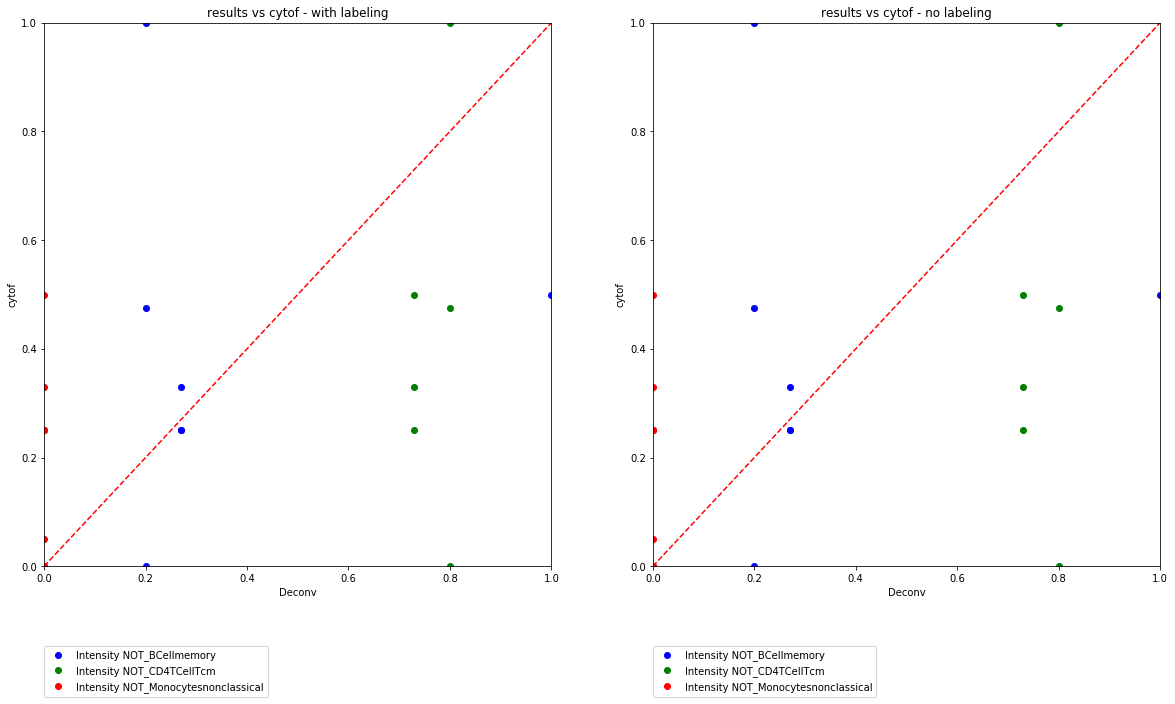

In [7]:
def describe_results(uuids,with_per_mixture_plot = False,with_mixtures_pca = False) : 
    if type(uuids) is str : 
        uuids = [uuids]
    
    for uuid in uuids : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        print("params : ")
        display(HTML(params.to_html()))


        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        best_known=best_results_and_known["known"]
        mapping = GlobalUtils.get_corospanding_cell_map_from_lists(best_known.index,best_results.index)
        best_known = best_known.rename(index=mapping)

        mutual_col = best_known.columns.intersection(best_results.columns)
        best_results = best_results[mutual_col]
        best_known = best_known[mutual_col]/100

        print("mixtures : ")
        display(HTML(best_results.to_html()))

        print("mixtures details :")
        display(HTML(best_results.corrwith(best_known,method="spearman").describe().to_frame().to_html()))

        cytof_plots.plot_mass_to_cytof_scatter_all_on_one(best_results,best_known,best_results)
        if with_per_mixture_plot : 
            cytof_plots.plot_mass_to_cytof_scatter(best_results,best_known,best_results)
        if with_mixtures_pca : 
            plot_results_vs_known_pca(best_results,best_known)
describe_results('995566674')

# test

In [8]:
a = pd.DataFrame(index=range(3),columns=range(8),data=np.random.rand(3,8))
b = pd.DataFrame(index=[3,1,2],columns=range(8),data=np.random.rand(3,8))

In [9]:
met = lambda x,y : x.corrwith(y, axis=0, method="spearman")

met(a,b)


0    1.0
1   -1.0
2   -1.0
3    1.0
4    1.0
5   -1.0
6    1.0
7   -1.0
dtype: float64

In [10]:
b.shape

(3, 8)